In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

In [3]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def free_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
df = pd.read_csv('/kaggle/input/m-tech-dataset/m_tech.csv', index_col=0)
df.drop_duplicates(subset=['text'], inplace=True)
df.head(10)

,text,target
0,негатив к вам и горячей линии которые нафиг н...,0
1,перестаньте впаривать клиентам дополнительные ...,1
2,продавец предложил наклеить защитную плёнку з...,1
3,продавец режил продать нам товар почему то по ...,1
4,навязанные услуги ( без моего согласия) на сум...,1
5,оператор проигнорировала информацию об ошибке ...,0
6,"сотрудник мало того, что задал вопросы по пово...",1
7,"электронные талоны в приложении не работают, п...",2
8,приложение не работало чтобы получить талон.,2
9,"хотели оформить заказ через приложение,но сотр...",1


In [8]:
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(df,model, tokenizer):
    full_embeddins=[]
    for i in df.index:
        text=df.loc[i,"text"]
        t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in t.items()})
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        full_embeddins.append(embeddings[0].cpu().numpy())
    return full_embeddins



tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [9]:
df

,text,target
0,негатив к вам и горячей линии которые нафиг н...,0
1,перестаньте впаривать клиентам дополнительные ...,1
2,продавец предложил наклеить защитную плёнку з...,1
3,продавец режил продать нам товар почему то по ...,1
4,навязанные услуги ( без моего согласия) на сум...,1
...,...,...
2832,почему отключили электронную очередь через пол...,2
2833,очередь на кассе. продавцы не торопятся с зака...,7
2834,"профессионализма менеджеру бы, да и внимания к...",6
2835,сотрудник на выдаче заказа потребовал документ...,2


In [10]:
!pip install pymorphy2
import pymorphy2
import re

def clean_text(data):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        data = data.replace(p, f' {p} ')  
    data=re.sub(r'\n', ' ', data)
    data = re.sub('  ', " ", data)
    data = data.lower()
    data=re.sub(r'[0-9.,!?\'\:)("]', ' ',data)
    data=re.sub('[^\x00-\x7Fа-яА-Я]', '', data)
    data = re.sub('  ', " ", data)
    return data

morph = pymorphy2.MorphAnalyzer()
def lemmatize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return " ".join(res)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.3 MB/s eta 0:00:0000:0100:01


In [11]:
%%time
df.loc[:,"clean_text"]=df.text.apply(lambda x:clean_text(x))
df.loc[:,"lem_text"]=df.clean_text.apply(lambda x:lemmatize(x))

CPU times: user 33.9 s, sys: 0 ns, total: 33.9 s
Wall time: 33.9 s


In [12]:
new_columns=['оператор',
 'поддержка',
 'обращение',
 'продавец',
 'консультант',
 'очередь',
 'персонал',
 'вежливость',
 'сотрудник',
 'касса',
 'компетентность',
 'время']

In [13]:
def create_columns(df):
    df["lenght"]=df.text.apply(lambda x:len(x))
    df[new_columns]=0
    for i in df.index:
        s=df.loc[i].lem_text
        col_to_update=list(set(s.split()).intersection(set(new_columns)))
        df.loc[i,col_to_update]=1


In [14]:
create_columns(df)

In [15]:
df

,text,target,clean_text,lem_text,lenght,оператор,поддержка,обращение,продавец,консультант,очередь,персонал,вежливость,сотрудник,касса,компетентность,время
0,негатив к вам и горячей линии которые нафиг н...,0,негатив к вам и горячей линии которые нафиг н...,негатив к вы и горячий линия который нафиг не ...,83,0,0,0,0,0,0,0,0,0,0,0,0
1,перестаньте впаривать клиентам дополнительные ...,1,перестаньте впаривать клиентам дополнительные ...,перестать впаривать клиент дополнительный това...,121,0,0,0,0,0,0,0,0,0,0,0,0
2,продавец предложил наклеить защитную плёнку з...,1,продавец предложил наклеить защитную плнку за...,продавец предложить наклеить защитный плнка за...,191,0,0,0,1,0,0,0,0,0,0,0,0
3,продавец режил продать нам товар почему то по ...,1,продавец режил продать нам товар почему то по ...,продавец режить продать мы товар почему то по ...,63,0,0,0,1,0,0,0,0,0,0,0,0
4,навязанные услуги ( без моего согласия) на сум...,1,навязанные услуги без моего согласия на сумм...,навязать услуга без мой согласие на сумма рубль,59,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2832,почему отключили электронную очередь через пол...,2,почему отключили электронную очередь через пол...,почему отключить электронный очередь через пол...,161,0,0,0,0,0,1,0,0,1,0,0,0
2833,очередь на кассе. продавцы не торопятся с зака...,7,очередь на кассе продавцы не торопятся с зака...,очередь на касса продавец не торопиться с зака...,102,0,0,0,1,0,1,0,0,0,1,0,0
2834,"профессионализма менеджеру бы, да и внимания к...",6,профессионализма менеджеру бы да и внимания к ...,профессионализм менеджер бы да и внимание к кл...,64,0,0,0,0,0,0,0,0,0,0,0,0
2835,сотрудник на выдаче заказа потребовал документ...,2,сотрудник на выдаче заказа потребовал документ...,сотрудник на выдача заказ потребовать документ...,744,0,0,0,0,0,1,0,0,1,1,0,1


In [16]:
df.columns

Index(['text', 'target', 'clean_text', 'lem_text', 'lenght', 'оператор',
       'поддержка', 'обращение', 'продавец', 'консультант', 'очередь',
       'персонал', 'вежливость', 'сотрудник', 'касса', 'компетентность',
       'время'],
      dtype='object')

In [17]:
from sklearn.model_selection import train_test_split
y=df.target
X=df.drop(["target"],axis=1)
x_train, x_test, y_train, y_test=train_test_split(X,y,test_size=0.33,random_state=42,stratify=y)

In [18]:
#получаем эмбеддинги с помощью берта
#сжимаем признаковое пространство
from sklearn.decomposition import PCA
embeddings=np.array(embed_bert_cls(pd.DataFrame(x_train.text,columns=['text']),model, tokenizer))
centered = embeddings - embeddings.mean() # центрируем

pca = PCA(n_components=150)
pca_decomp = pca.fit_transform(centered)

In [19]:
# кластеризуем наше признаковое пространство на 20 признаков
from sklearn.cluster import KMeans

n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_decomp)

#x_train['TextCluster'] = kmeans.labels_

dists_columns = [f'DistanceToCluster_{i}' for i in range(n_clusters)]#создаем названия колонкам 

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,DistanceToCluster_0,DistanceToCluster_1,DistanceToCluster_2,DistanceToCluster_3,DistanceToCluster_4,DistanceToCluster_5,DistanceToCluster_6,DistanceToCluster_7,DistanceToCluster_8,DistanceToCluster_9,DistanceToCluster_10,DistanceToCluster_11,DistanceToCluster_12,DistanceToCluster_13,DistanceToCluster_14,DistanceToCluster_15,DistanceToCluster_16,DistanceToCluster_17,DistanceToCluster_18,DistanceToCluster_19
0,0.636631,0.772191,0.716974,0.672398,0.639789,0.814797,0.639109,0.722600,0.713507,0.726693,0.775124,0.746402,0.824060,0.697992,0.648812,0.883172,0.734737,0.639216,0.610987,0.573559
1,0.623591,0.735447,0.585074,0.572569,0.641171,0.736276,0.687179,0.556323,0.585898,0.695263,0.726098,0.773568,0.840421,0.660173,0.650181,0.832409,0.714762,0.597868,0.703902,0.701627
2,0.714897,0.619731,0.757666,0.731009,0.690194,0.796495,0.753398,0.810586,0.757869,0.637305,0.861098,0.665400,0.787628,0.763453,0.791959,0.728438,0.678932,0.676734,0.801463,0.670397
3,0.598637,0.777744,0.643921,0.589858,0.521999,0.863756,0.575138,0.658657,0.740987,0.669737,0.665574,0.836929,0.771544,0.726276,0.583651,0.884416,0.756438,0.686764,0.628254,0.677889
4,0.494115,0.707906,0.638225,0.558002,0.502722,0.781803,0.552124,0.565203,0.629264,0.647830,0.647668,0.781808,0.810130,0.611203,0.498596,0.883263,0.740068,0.546441,0.576592,0.540325


In [20]:
x_train=pd.concat([x_train.reset_index(),dists_df],axis=1)

In [21]:
embeddings=np.array(embed_bert_cls(pd.DataFrame(x_test.text,columns=['text']),model, tokenizer))
centered = embeddings - embeddings.mean() # центрируем
#200
pca_decomp_test = pca.transform(centered)

In [22]:
#x_test['TextCluster'] = kmeans.labels_
dists_df_test = pd.DataFrame(
    data=kmeans.transform(pca_decomp_test),
    columns=dists_columns
)



In [23]:
x_test=pd.concat([x_test.reset_index(),dists_df_test],axis=1)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [25]:
#создаем признаки с помощью tfidf
tfidf = TfidfVectorizer(
)
tfidf_train=tfidf.fit_transform(x_train["lem_text"]).toarray()
tfidf_test=tfidf.transform(x_test["lem_text"]).toarray()

In [26]:
x_train['TotalTfIdf'] = tfidf_train.sum(axis=1)
x_train['MaxTfIdf'] = tfidf_train.max(axis=1)
x_train['MeanTfIdf'] = tfidf_train.mean(axis=1)
x_test['TotalTfIdf'] = tfidf_test.sum(axis=1)
x_test['MaxTfIdf'] = tfidf_test.max(axis=1)
x_test['MeanTfIdf'] = tfidf_test.mean(axis=1)


In [27]:
x_train=x_train.drop(['lem_text','clean_text','text','index'],axis=1)
x_test=x_test.drop(['lem_text','clean_text','text','index'],axis=1)

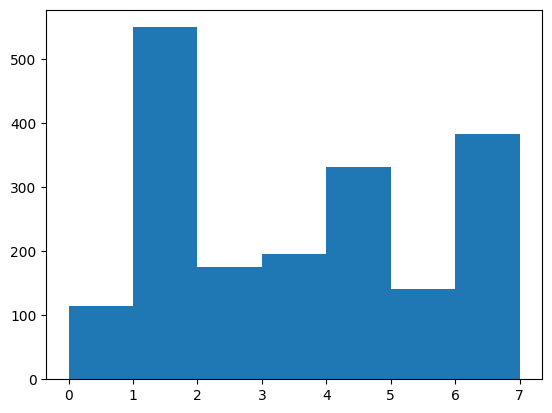

In [28]:
plt.hist(y_train,bins=7)
plt.show()

In [30]:
from catboost import CatBoostClassifier
model=CatBoostClassifier()
model.fit(x_train,y_train)


Learning rate set to 0.081738
0:	learn: 1.9809708	total: 90.8ms	remaining: 1m 30s
1:	learn: 1.8902424	total: 115ms	remaining: 57.2s
2:	learn: 1.8168486	total: 139ms	remaining: 46.2s
3:	learn: 1.7553922	total: 162ms	remaining: 40.4s
4:	learn: 1.7106286	total: 187ms	remaining: 37.2s
5:	learn: 1.6679735	total: 213ms	remaining: 35.3s
6:	learn: 1.6318601	total: 237ms	remaining: 33.6s
7:	learn: 1.5939798	total: 262ms	remaining: 32.4s
8:	learn: 1.5651882	total: 284ms	remaining: 31.3s
9:	learn: 1.5346717	total: 308ms	remaining: 30.5s
10:	learn: 1.5104728	total: 331ms	remaining: 29.7s
11:	learn: 1.4859221	total: 354ms	remaining: 29.1s
12:	learn: 1.4612790	total: 377ms	remaining: 28.6s
13:	learn: 1.4394462	total: 400ms	remaining: 28.2s
14:	learn: 1.4196242	total: 425ms	remaining: 27.9s
15:	learn: 1.4005142	total: 450ms	remaining: 27.7s
16:	learn: 1.3810145	total: 475ms	remaining: 27.4s
17:	learn: 1.3644185	total: 500ms	remaining: 27.3s
18:	learn: 1.3510318	total: 524ms	remaining: 27s
19:	learn: 

In [31]:
print(f"accurancy: {accuracy_score(y_test,model.predict(x_test))}")
print(f"f1: {f1_score(y_test,model.predict(x_test),average='micro')}")

accurancy: 0.630901287553648
f1: 0.630901287553648


In [45]:
model.save_model(
    'catboost_model_m_tech',
    format="cbm"                  
)

In [34]:
import pickle

pickle.dump(tfidf, open("tfidf.pickle", "wb"))


In [44]:
pickle.dump(pca, open("pca.pickle", "wb"))

In [43]:
pickle.dump(kmeans, open("kmeans.pickle", "wb"))

In [71]:
print(f"pymorphy2=={pymorphy2.__version__}")
print(f"pandas=={pd.__version__}")
print(f"numpy=={np.__version__}")
print(f"catboost=={catboost.__version__}")
print(f"torch=={torch.__version__}")
print(f"transformers=={transformers.__version__}")

pymorphy2==0.9.1
pandas==2.1.4
numpy==1.24.3
catboost==1.2.2
torch==2.0.0
transformers==4.36.0
